This notebook goes through how to draw a **parametric curve** and **convert** it into a **shape**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.post_processing import hard_binarization
from spomso.cores.geom_2d import ParametricCurve


# PARAMETERS

In [2]:
# size of the volume
co_size = 6, 6
# resolution of the volume
co_resolution = 600

show = "FIELD" # BINARY, FIELD
show_midplane = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Define the **parametric function** of the **parametric curve**:

In [4]:
def polar_curve(t, radius1, radius2, f1, f2, ):

    r = radius1 + radius2*np.cos(f2*t*2*np.pi)

    x = r * np.cos(f1 * t * 2 * np.pi)
    y = r * np.sin(f1 * t * 2 * np.pi)

    return np.asarray((x, y))

The **closed parametric curve** can also be converted into a **shape**. Where the enclosed area will be on the inside of the **shape**.

In [5]:
shape = True

Create a **parametric curve** geometry from the function defining the **parametric curve**. The parameters of the function are **2**, **0.5**, **1**, and **3**.The curve is evaluated for **201** values of the parameter **t** in range from **0** to **1**.

In [6]:
curve = ParametricCurve(polar_curve, (2, 0.5, 1, 3), (0, 1, 201), closed=True)

Since the **parametric curve** is closed it can be converted into a **shape** (works only if the curve is closed):

In [7]:
if shape:
    curve.shape()

To get the **sign/interior** of a SDF:

In [8]:
curve_sign = curve.sign(direct=True)

The line can be recovered with:

In [9]:
curve.boundary()

<function spomso.cores.modifications.ModifyObject.boundary.<locals>.new_geo_object(co, *params)>

The interior can be recovered with a function:

In [10]:
curve.recover_volume(curve_sign)

<function spomso.cores.modifications.ModifyObject.recover_volume.<locals>.new_geo_object(co, *params)>

The interior can be redefined with a function:

In [11]:
# curve.define_volume(some_sign_function, some_sign_function_parameters)

In general a **line** or a **curve** can be converted into a **surface** by applying **rounding** with some rounding radius, in this case **0.1**:

In [12]:
if not shape:
    curve.rounding(0.1)

## EVALUATE

Evaluate the SDF of the **parametric curve** to create a signed distance field 2D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [13]:
curve_pattern = curve.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [14]:
if show_midplane:
    field = smarter_reshape(curve_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

# PLOT

Drawing results...
(601, 601)


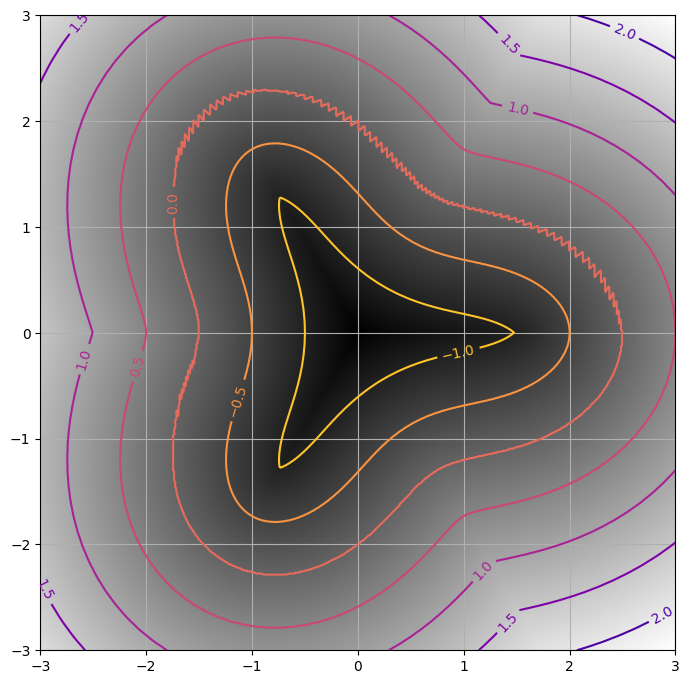

In [15]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[1]/2, co_size[1]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    print(field.shape)
    ax.imshow(field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()